In [ ]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from keras.utils.np_utils import to_categorical
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet101
# from tensorflow.keras.applications import Xception
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
#It should be 
from tensorflow.keras.layers import Input
from keras import Model
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from sklearn import preprocessing
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from zipfile import ZipFile
import numpy as np
from tensorflow import keras
from pydub import AudioSegment
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks
from imblearn.over_sampling import SMOTE
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Spectrogram For Train Test/Deep Breath Cov-Non Cov'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [ ]:
disease_types = ['Covid', 'Non Covid']

train_dir = data_dir = '/content/drive/MyDrive/Spectrogram For Train Test/Deep Breath Cov-Non Cov'

train_data = []

for index, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append([sp + "/" + file, index, sp])
        
train = pd.DataFrame(train_data, columns = ['File', 'ID','Disease Type'])
pd.set_option('display.max_columns', None) 
train.tail(12)

,File,ID,Disease Type
1388,Non Covid/SopKRSJ4JcY36rGE8X4wRE7vPHl2_breathi...,1,Non Covid
1389,Non Covid/PZhCH5PyO8RD2FPFQbeCmuGB5q33_breathi...,1,Non Covid
1390,Non Covid/BPQxhBSlypXZICqfsmZcUYBxFmz1_breathi...,1,Non Covid
1391,Non Covid/MVhuzBxevwRieaQMwOCfiyCCzUK2_breathi...,1,Non Covid
1392,Non Covid/I5gTlFVoKbVFGCKxwV6QXSOdkZN2_breathi...,1,Non Covid
1393,Non Covid/FYXJ3Brvf1Wi8YdILInJ19dSiJM2_breathi...,1,Non Covid
1394,Non Covid/IBjSkzn7W6WpVSw49EXPM2ME75t2_breathi...,1,Non Covid
1395,Non Covid/6BGTwwcsLoZpqSMhSzFeT2Z7Pqr2_breathi...,1,Non Covid
1396,Non Covid/mNcNjQMsv8aZXFGuguWbLdmkOQk2_breathi...,1,Non Covid
1397,Non Covid/kIpoXJzNPWQXgvSIdHiJj2kBK6n1_breathi...,1,Non Covid


In [ ]:
IMAGE_SIZE = 224
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print(X_Train.shape)

1400it [01:05, 21.49it/s]


(1400, 224, 224, 3)


In [ ]:
y_train = train['ID'].values
#y_train = to_categorical(y_train, num_classes=2)
print(len(y_train))

1400


In [ ]:
sm = SMOTE(sampling_strategy={0: 750},random_state=42)
X = np.array(X_Train)
X_resampled, y_resampled = sm.fit_resample(X.reshape(X.shape[0], -1), np.array(y_train))

X_resampled = X_resampled.reshape(-1, 224, 224, 3)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, list(y_resampled), test_size=0.10, random_state=42,stratify= y_resampled)
print(len(y_train))

1884


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_Train, y_train, test_size=0.4)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# print ("Shape of an image in X_train: ", X_train[0].shape)
# print ("Shape of an image in X_test: ", X_test[0].shape)

In [ ]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test) 

In [ ]:
BATCH_SIZE =25
EPOCHS = 100
SIZE = 224
N_ch=3

In [ ]:
from keras.applications import vgg16
def build_VGG16():
    # img_rows, img_cols = 150, 150  #image shape = 224 X 224
    img_rows, img_cols = 224 , 224

    vgg = vgg16.VGG16(weights = 'imagenet', include_top = False, 
              input_shape = (img_rows, img_cols, 3)) # image net has more neurons but we have only 2 hence we are not using the top layer

    # Here we freeze the last 4 layers 
    # Layers are set to trainable as True by default
    for layer in vgg.layers:
      layer.trainable = False  # just copies the weights 
    
    # Let's print our layers 
    for (i,layer) in enumerate(vgg.layers):
      print(str(i) + " "+ layer.__class__.__name__, layer.trainable)
    
    return vgg

In [ ]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    # top_model = Dense(1024,activation='relu')(top_model)
    # top_model = Dense(1024,activation='relu')(top_model)
    #top_model = Dense(1024,activation='relu')(top_model)
    # top_model = Dense(512,activation='relu')(top_model)
    # top_model = Dense(128,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='sigmoid')(top_model)
    return top_model 

In [ ]:
model = build_VGG16()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('vgg16_Model.hdf5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2,
                        zoom_range=0.2, 
                        horizontal_flip=True, 
                        vertical_flip=True) 

datagen.fit(X_train)

58889256/58889256 [==============================] - 0s 0us/step
0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model

num_classes = 2
FC_Head = lw(model, num_classes)
model = Model(inputs = model.input, outputs = FC_Head)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.models import Model
# model.add(Conv2D(kernel_size=(3,3),filters=128,input_shape=(150, 150, 3),activation="relu",padding="valid"))
# model.add(Conv2D(kernel_size=(3,3),filters=64,input_shape=(150, 150, 3),activation="relu",padding="valid"))
# optimizer = SGD(lr=0.000001,  decay=0.0)

optimizer = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
model.compile(loss = 'categorical_crossentropy', optimizer=optimizer,metrics = ['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
print(X_train.shape[0],X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(y_train.shape[0],y_train.shape[1])


1884 224 224 3
1884 2


In [ ]:
X_train.shape[0]
history= model.fit(tf.expand_dims(X_train, axis=-1),y_train,batch_size=BATCH_SIZE,steps_per_epoch=50,epochs=EPOCHS, verbose=1, callbacks=[annealer, checkpoint],validation_data=(X_test, y_test))

# history = model.fit(datagen.flow(tf.expand_dims(X_train, axis=-1), y_train, batch_size=BATCH_SIZE),
#                steps_per_epoch=10,
#                epochs=EPOCHS,
#                verbose=1,
#                callbacks=[annealer, checkpoint],
#                validation_data=(X_test, y_test))

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.6887 - accuracy: 0.6368
Epoch 1: val_loss improved from inf to 0.68201, saving model to vgg16_Model.hdf5
50/50 [==============================] - 19s 180ms/step - loss: 0.6887 - accuracy: 0.6368 - val_loss: 0.6820 - val_accuracy: 0.6429 - lr: 1.0000e-05
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.6702 - accuracy: 0.6532
Epoch 2: val_loss improved from 0.68201 to 0.68067, saving model to vgg16_Model.hdf5
50/50 [==============================] - 9s 174ms/step - loss: 0.6702 - accuracy: 0.6532 - val_loss: 0.6807 - val_accuracy: 0.6429 - lr: 1.0000e-05
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.6336
Epoch 3: val_loss improved from 0.68067 to 0.67905, saving model to vgg16_Model.hdf5
50/50 [==============================] - 8s 153ms/step - loss: 0.6909 - accuracy: 0.6336 - val_loss: 0.6791 - val_accuracy: 0.6429 - lr: 1.0000e-05
Epoch 4/100
50/50 [

In [ ]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']



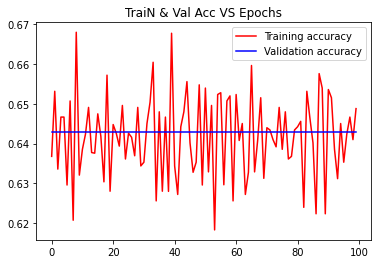

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()



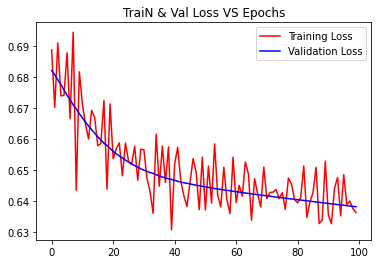

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('TraiN & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
model.load_weights("vgg16_Model.hdf5")
score = model.evaluate(X_test,y_test ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

7/7 [==============================] - 6s 455ms/step - loss: 0.6382 - accuracy: 0.6429
Test Loss: 0.6381685733795166
Test accuracy: 64.28571343421936


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np

pred = model.predict(X_test)
rounded_labels_1 = np.argmax(pred, axis=1)
rounded_labels_2 = np.argmax(y_test, axis=1)
rounded_labels_1[1]
rounded_labels_2[1]
print(accuracy_score(rounded_labels_2,rounded_labels_1))
print(confusion_matrix(rounded_labels_2,rounded_labels_1))
print(classification_report(rounded_labels_2,rounded_labels_1))

7/7 [==============================] - 1s 130ms/step
0.6428571428571429
[[  0  75]
 [  0 135]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.64      1.00      0.78       135

    accuracy                           0.64       210
   macro avg       0.32      0.50      0.39       210
weighted avg       0.41      0.64      0.50       210



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
  win = window(frameSize)
  hopSize = int(frameSize - np.floor(overlapFac * frameSize))   
  samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)    
  cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
  samples = np.append(samples, np.zeros(frameSize))
  frames = stride_tricks.as_strided(samples, shape=(int(cols), frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
  frames *= win
  return np.fft.rfft(frames)    

""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=44100, factor=20.):
  timebins, freqbins = np.shape(spec)

  scale = np.linspace(0, 1, freqbins) ** factor
  scale *= (freqbins-1)/max(scale)
  scale = np.unique(np.round(scale))

  newspec = np.complex128(np.zeros([timebins, len(scale)]))
  for i in range(0, len(scale)):        
       if i == len(scale)-1:
          newspec[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
       else:        
          newspec[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)

  allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
  freqs = []
  for i in range(0, len(scale)):
      if i == len(scale)-1:
          freqs += [np.mean(allfreqs[int(scale[i]):])]
      else:
          freqs += [np.mean(allfreqs[int(scale[i]):int(scale[i+1])])]
  return newspec, freqs

""" plot spectrogram"""
def plotstft(audiopath, binsize=2**10, plotpath=None, colormap="jet"):
  samplerate, samples = wav.read(audiopath)
  s = stft(samples, binsize)
  sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)
  ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel
  return ims
def plot_save_return_address(path_to_get, sample_num):
  ims = plotstft(path_to_get)
  plt.figure(figsize=(15, 7.5))
  plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap="jet", interpolation="none")
  plt.axis("off")
  # var = path_to_get.split("/")
  # name = var[-2]+"_"+(var[-1].split("."))[0]
  plotpath ='/content/'+"sample"+str(sample_num)+"_spectrogram.png"
  plt.savefig(plotpath, bbox_inches="tight")
  return plotpath

In [ ]:
breath_expectation={'01': 'c', '02': 'n', '03': 'n', '04': 'n', '05': 'n', '06': 'c', '07': 'n', '08': 'c', '09': 'c', 10: 'c', 11: 'n', 12: 'n', 13: 'n', 14: 'c', 15: 'n', 16: 'n', 17: 'c', 18: 'c', 19: 'n', 20: 'c', 21: 'c', 22: 'n', 23: 'c', 24: 'n', 25: 'n'}
# breath_expectation={'01': 'c', '02': 'c', '03': 'c', '04': 'c', '05': 'c', '06': 'c', '07': 'n', '08': 'c', '09': 'c', 10: 'c', 11: 'c', 12: 'c', 13: 'c', 14: 'c', 15: 'c', 16: 'n', 17: 'c', 18: 'n', 19: 'c', 20: 'c', 21: 'n', 22: 'n', 23: 'c', 24: 'n', 25: 'c'}
breath_reality={}

common_path="/content/drive/MyDrive/Collected Data/Sample  ("
#current image path
for file_num in range(1,26):
  if len(str(file_num))==1:
    file_num='0'+str(file_num)
  current_mp3_path=common_path+str(file_num)+")/sample"+str(file_num)+"_breath.mp3"
  #convert mp3 to wav

  # output file location
  wav_file_path = '/content/'+"sample"+str(file_num)+"_breath.wav"
  # reading the .mp3 audio file exporting to .wav format
  AudioSegment.from_mp3(current_mp3_path).export(wav_file_path, format="wav")

  spectrogram_file_path= plot_save_return_address(wav_file_path, file_num)

  img = tf.keras.preprocessing.image.load_img(spectrogram_file_path, target_size=(224,224))

  # Open an image file
  # Convert the image to a numpy array
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  # Add an extra dimension to the image (since VGG16 expects a 4D input)
  img_array = np.expand_dims(img_array, axis=0)
  # Preprocess the image (subtracting the mean RGB value)
  img_array = tf.keras.applications.resnet_v2.preprocess_input(img_array)
  # Use the model to classify the image
  predictions = model.predict(img_array)
  print('--------------------------------------------------------')
  print(predictions ,'for Sample No= ',file_num)
  print("Covid possibility:", format(predictions[0][0], '.4f'))
  #print("Covid possibility:", format(predictions[0][0], '.4f'))
  # print("Normal possibility:", format(predictions[0][2]+predictions[0][1], '.4f'))
  print("Normal possibility:", format(predictions[0][1], '.4f'))
  # if float(format(predictions[0][0], '.4f')) > float(format(predictions[0][2]+predictions[0][1], '.4f')):
  if float(format(predictions[0][0], '.4f')) > float(format(predictions[0][1], '.4f')):
    print("covid")
    breath_reality[file_num]='c'
  # elif float(format(predictions[0][0], '.4f')) < float(format(predictions[0][2]+predictions[0][1], '.4f')):
  elif float(format(predictions[0][0], '.4f')) < float(format(predictions[0][1], '.4f')):
    print("normal")
    breath_reality[file_num]='n'
  else:
     print("lol")
  # if float(format(predictions[0][0], '.2f')) > float(format(predictions[0][1], '.2f')):
  #   print("covid")
  #   breath_reality[file_num]='c'
  # elif float(format(predictions[0][0], '.2f')) < float(format(predictions[0][1], '.2f')):
  #   print("normal")
  #   breath_reality[file_num]='n'
  # else:
  #   print("lol")

print(breath_expectation)
print(breath_reality)
match_count=0
for key in breath_reality:
   if breath_expectation[key]==breath_reality[key]:
     match_count+=1
print(match_count)

correct_cov = 0
total_cov = 0
total_non = 0
correct_non = 0
for i in (breath_reality):
  # print("Sample",i,"real =", breath_expectation[i],"predict =",breath_reality[i])
  if breath_expectation[i] == "c":
    total_cov += 1
  if breath_expectation[i] == "n":
     total_non += 1
  if breath_expectation[i] == "c" and breath_expectation[i] == breath_reality[i]:
    correct_cov += 1
  if breath_expectation[i] == "n" and breath_expectation[i] == breath_reality[i]:
    correct_non += 1

print("total cov =", total_cov, "total non =", total_non)
print("correct cov =", correct_cov,"incorrect cov=", total_cov-correct_cov)
print("correct non =", correct_non,"incorrect non=", total_non-correct_non)


#breath_expectation={'01': 'c', '02': 'n', '03': 'n', '04': 'n', '05': 'n', '06': 'c', '07': 'n', '08': 'c', '09': 'c', 10: 'c', 11: 'n', 12: 'n', 13: 'n', 14: 'c', 15: 'n', 16: 'n', 17: 'c', 18: 'c', 19: 'n', 20: 'c', 21: 'c', 22: 'n', 23: 'c', 24: 'n', 25: 'n'}

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model.load_weights("vgg16_Model.hdf5")
model.save("/content/drive/MyDrive/Model Saves/VGG16 Deep Breath")
score = model.evaluate(X_test,y_test ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

7/7 [==============================] - 1s 146ms/step - loss: 0.6382 - accuracy: 0.6429
Test Loss: 0.6381685733795166
Test accuracy: 64.28571343421936
